In [26]:
# code for loading the format for the notebook
import os

# path : store the current path to convert back to it later
path = os.getcwd()
os.chdir(os.path.join('..', 'notebook_format'))
from formats import load_style
load_style()

In [1]:
os.chdir(path)
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from sklearn.datasets import fetch_20newsgroups

from subprocess import call
from zipfile import ZipFile

# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

%watermark -a 'Ethen' -d -t -v -p numpy,tensorflow,sklearn,gensim

Ethen 2017-07-25 16:31:25 

CPython 3.5.2
IPython 5.4.1

numpy 1.13.1
tensorflow 1.1.0
sklearn 0.18.1


# Word2vec (Skipgram)

At a high level `Word2Vec` is a unsupervised learning algorithm that uses a shallow neural network (with one hidden layer) to learn the vectorial representations of all the unique words/phrases for a given corpus. The advantage that word2vec offers is it tries to preserve the semantic meaning behind those terms. For example, a document may employ the words "dog" and "canine" to mean the same thing, but never use them together in a sentence. Ideally, the word2vec algorithm would be able to learn the context and place them together in similar vector semantic space.

We'll start off by using the Gensim's implementation of the algorithm to provide a high-level intuition.

In [18]:
newsgroups_train = fetch_20newsgroups(subset = 'train')

# gensim’s Word2vec expects a sequence of sentences as its input,
# where each sentence a list of words. We'll be lazy and not perform
# any sort of text preprocessing
documents = [doc.strip().split() for doc in newsgroups_train.data]

# exmaple output of the data
print('raw data:\n\n', newsgroups_train.data[0])
print('example input:\n', documents[0])

raw data:

 From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----





example input:
 ['From:', 'lerxst@wam.umd.edu', "(where's", 'my', 'thing)', 'Subject:', 'WHAT', 'car', 'is', 'this!?', 'Nntp-Posting-Host:', 'rac3.wam.umd.edu', 'Organization:', 'University', 'of', 'Maryland,', 'College', 'Park', 'Lines:', '15', 'I', 'was', 'wonderi

In [23]:
# apart from the input sentence, the only additional paramter
# we'll set is to specify use all possible cpu to train the model
workers = cpu_count()
word2vec_checkpoint = 'word2vec'

word2vec = Word2Vec(documents, workers = workers)
word2vec.save(word2vec_checkpoint)
word2vec = Word2Vec.load(word2vec_checkpoint)

# obtain the learned word vectors (.wv.syn0)
# and the vocabulary/word that corresponds to each word vector
word_vectors = pd.DataFrame(word2vec.wv.syn0,
                            index = word2vec.wv.index2word)

print(word_vectors.shape)
word_vectors.head()

(44593, 100)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
the,0.023563,-2.233488,1.669341,0.415943,0.650172,-2.350407,0.366107,-1.342206,1.275405,-2.084954,...,-0.638189,-0.339148,-0.424759,-1.191694,-1.537094,0.685526,-1.552187,1.137069,1.698536,-0.203164
to,-1.275725,-0.323098,1.490118,-1.649044,0.943990,-2.243789,-0.352389,0.913918,-0.007678,-2.101020,...,1.047411,1.412227,1.244074,0.526244,2.408385,1.202359,-1.039252,0.489790,2.798970,-1.336727
of,-1.659646,-1.866756,3.310670,-0.185935,-1.897423,-0.170021,1.136050,-2.220443,0.585102,0.266670,...,-1.246955,0.713795,0.782606,1.718141,-2.802217,-1.187473,0.222166,-1.900159,-1.893901,-0.989673
a,1.071501,-3.333133,0.297913,-0.999243,-0.786862,-1.774176,-1.010605,-0.971707,1.416180,-1.936583,...,-3.365023,-1.177814,1.376837,1.049419,-0.825544,-0.192187,0.275484,1.075993,2.368169,-0.549991
and,0.202602,-0.059123,2.400447,1.077665,1.350307,-0.936709,0.329720,-0.947536,1.280276,-1.987152,...,0.512694,-1.145365,0.811848,-1.594738,0.934255,-0.710259,-0.924183,-1.264377,-0.637149,0.633192


After the model has learned the word vectors, we can use them to look up related words and phrases (words that have similar semantic meaning) for a given term of interest.

In [24]:
word2vec.wv.most_similar(positive = ['computer'], topn = 5)

[('network', 0.8267158269882202),
 ('keyboard', 0.8047323822975159),
 ('application', 0.8029298782348633),
 ('board', 0.8025233745574951),
 ('machine', 0.7981600761413574)]

## Model Details

The way the model works underneath the hood is that trains a neural network by do the following: Given a specific word in the middle of a sentence (the input word), look at the words nearby and pick one at random. To be explicit, there is actually a **window size** hyperparameter to the algorithm that quantifies the word "nearby". A typical window size might be 5, meaning 5 words behind and 5 words ahead (10 in total).

The diagram below shows some of the training samples (word pairs) we would take from the sentence "The quick brown fox jumps over the lazy dog." We'll used a small window size of 2 just for the example. The word highlighted in blue is the input word.

<img src="img/skipgram.png" width="50%" height="50%">

After feeding a bunch of word pairs to the network, it is going to tell us the probability for every word in our vocabulary being "nearby" word that we chose. The output probabilities are going to relate to how likely it is find each vocabulary word nearby our input word. For example, if we gave the trained network the input word "Soviet", the output probabilities should be much higher for words like "Union" and "Russia" than for unrelated words like "watermelon" and "kangaroo".


So how is this all represented? First of all, we know we can't feed a word just as a text string to a neural network (or probably any machine learning model), i.e. we need a way to represent the words to the network. To do this, we first build a vocabulary of words from our training documents. We'll assume that our corpus has a vocabulary size of 10,000.

We’re going to represent an input word like "ants" as a one-hot vector. This vector will have 10,000 components (one for every unqiue word in our vocabulary) and we'll place a "1" in the position corresponding to the word "ants", and 0s in all of the other positions. The output of the network is a single vector (also with 10,000 components) containing, for every word in our vocabulary, the probability that a randomly selected nearby word is that vocabulary word. Here’s the architecture of our single-layer neural network.

<img src="img/word2vec_architecture.png" width="60%" height="60%">

There is no activation function on the hidden layer neurons, but the output neurons use softmax. We’ll come back to this later.

When training this network on word pairs, the input is a one-hot vector representing the input word and the training output is also a one-hot vector representing the output word. But when we evaluate the trained network on an input word, the output vector will actually be a probability distribution (i.e., a bunch of floating point values, not a one-hot vector).

## The Hidden Layer

Let's say that we wish to learn word vectors with 300 features. The number of features is a hyperparameter that we would have to tune to our application to see which one yields the best result. So the hidden layer is going to be represented by a weight matrix with 10,000 rows (one for every word in our vocabulary) and 300 columns (one for every hidden neuron).

Now if we look at what would happen when we multiply the 1 x 10,000 one-hot vector representation of the word with a 10,000 x 300 matrix that represents the hidden layer's weight, it will effectively just select the matrix row corresponding to the "1". The following figure is a small example that does a matrix multiplication of a 1 x 5 one hot vector with a 5 x 2 hidden layer's weight to give you a visual. 

<img src="img/hidden_layer.png" width="70%" height="70%">

This means that the hidden layer of this model is really just operating as a lookup table. The output of the hidden layer is just the "word vector" for the input word.

## The Output Layer

The 1 x 300 word vector for "ants" then gets fed to the output layer. The output layer is a softmax regression classifier. There's another documentation on Softmax Regression [here](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/deep_learning/softmax.ipynb), but the gist of it is that each output neuron, one per word in our vocabulary will produce an output probability between 0 and 1 and the sum of all these output values will add up to 1.

Specifically, each output neuron has a weight vector which it multiplies against the word vector from the hidden layer, then it applies the function `exp(x)` to the result. Finally, in order to get the outputs to sum up to 1, we divide this result by the sum of the results from all 10,000 output nodes. Here’s an illustration of calculating the output probability for the word "car".

<img src="img/output_layer.png" width="70%" height="70%">

Note that neural network does not know anything about the offset of the output word relative to the input word. In other words, it does not learn a different set of probabilities for the word before the input versus the word after.

Recall that in the beginning of the documentation, we mentioned that the goal for word2vec is to represent each word in the corpus as the vector representation while trying to reserve semantic meaning. This means that if two different words have very similar "contexts" (that is, what words are likely to appear around them), then our model needs to output very similar results for these two words. And one way for the network to output similar context predictions for these two words is if the word vectors are similar. So to hit the notion home, if two words have similar contexts, then word2vec is motivated to learn similar word vectors for these two words!

# Improving Word2vec

You may have noticed that the skip-gram neural network contains a huge number of weights ... For our example with 300 features and a vocab of 10,000 words, that's 3M weights in the hidden layer and output layer each! Training this on a large dataset would be slow and prone to overfitting, so the word2vec authors introduced a number of tweaks to make training feasible.

- Treating common word pairs or phrases as single "words" in their model
- Subsampling frequent words to decrease the number of training examples
- Modifying the optimization objective with a technique they called "Negative Sampling", which causes each training sample to update only a small percentage of the model’s weights

It’s worth noting that subsampling frequent words and applying Negative Sampling not only reduced the compute burden of the training process, but also improved the quality of their resulting word vectors as well.


## Negative Sampling

Training a neural network means taking a training example and adjusting all of the neuron weights slightly so that it predicts that training sample more accurately. In other words, each training sample will tweak all of the weights in the neural network.

As we discussed above, the size of our word vocabulary means that our skip-gram neural network has a tremendous number of weights, all of which would be updated slightly by every one of our billions of training samples! Negative sampling addresses this by having each training sample only modify a small percentage of the weights, rather than all of them. Here’s how it works.

When training the network on the word pair ("fox", "quick"), we want the "correct output" of the network, that is the output neuron corresponding to "quick" to output a 1, and for all of the other thousands of output neurons to output a 0.

With negative sampling, we are instead going to randomly select just a small number of "negative" words (let’s say 5) to update the weights for. (In this context, a "negative" word is one for which we want the network to output a 0 for). We will also still update the weights for our “positive” word (which is the word “quick” in our current example).

> The paper says that selecting 5-20 words works well for smaller datasets, and we can get away with only 2-5 words for large datasets.

Recall that the output layer of our model has a weight matrix that's 300 x 10,000. So we will just be updating the weights for our positive word ("quick"), plus the weights for 5 other words that we want to output 0. That’s a total of 6 output neurons, and 1,800 weight values total. That’s only 0.06% of the 3M weights in the output layer!

In the hidden layer, only the weights for the input word are updated (this is true whether you’re using Negative Sampling or not).

## Mathematical Notation

This section goes back and re-visit the mathematical notation for the Word2vec skipgram, hopefully, the math won't look so daunting after having an understanding of the model from a non-mathematical standpoint.


\begin{align}
J_{\theta} 
&= arg\underset{\theta}{max} 
\prod_{(w, c) \in D} p(D = 1 \big| c, w; \theta) \prod_{(w, c) \in D'} p(D = 0 \big| c, w; \theta) \\
&= arg\underset{\theta}{max} 
\prod_{(w, c) \in D} p(D = 1 \big| c, w; \theta) \prod_{(w, c) \in D'} \big(1 - p(D = 1 \big| c, w; \theta)\big) \\
&= arg\underset{\theta}{max} 
\sum_{(w, c) \in D} log \big(p(D = 1 \big| c, w; \theta)\big) \sum_{(w, c) \in D'} log \big(1 - p(D = 1 \big| c, w; \theta)\big) \\
&= arg\underset{\theta}{max} 
\sum_{(w, c) \in D} log \big( \dfrac{1}{1 + \text{exp}(-v_c \cdot v_w)} \big) \sum_{(w, c) \in D'} log \big (1 - \dfrac{1}{1 + \text{exp}(-v_c \cdot v_w)} \big) \\
&= arg\underset{\theta}{max}
\sum_{(w, c) \in D} log \big( \dfrac{1}{1 + \text{exp}(-v_c \cdot v_w)} \big) \sum_{(w, c) \in D'} log \big (\dfrac{1}{1 + \text{exp}(v_c \cdot v_w)} \big) \\
\end{align}

# Tensorflow Implementation

In [2]:
def read_data():
    """Read data into a list of tokens/words"""
    filename = 'text8.zip'
    base_url = 'http://mattmahoney.net/dc/'

    if not os.path.isfile(filename):
        call('wget ' + base_url + filename, shell = True)
        
    with ZipFile(filename) as f:
        file = f.namelist()[0]
        
        # ensure compatibility each python2 and python3's str type
        # https://stackoverflow.com/questions/37689802/what-is-tensorflow-compat-as-str
        data = tf.compat.as_str(f.read(file)).split()

    return data

In [3]:
words = read_data()
print('data:', words[:4])
print('data size {}'.format(len(words)))

data: ['anarchism', 'originated', 'as', 'a']
data size 17005207


In [4]:
from collections import Counter


def build_dataset(words, vocabulary_size):
    count = Counter(words).most_common(vocabulary_size - 1)

    # build up word index and replaced the words by its assigned indices
    data = []
    unknown_count = 0
    word_index = {word: idx for idx, (word, _) in enumerate(count)}

    for word in words:
        if word in word_index:
            idx = word_index[word]
        else:
            idx = 0
            unknown_count += 1

        data.append(idx)

    # 'UNK' flag for out of vocabulary word
    unknown = 'UNK', unknown_count
    count.append(unknown)
    word_index_rev = {idx: word for word, idx in word_index.items()}
    return data, count, word_index, word_index_rev

In [5]:
# TODO : ??? do we need to return a 4 element tuple
vocabulary_size = 50000
data, count, word_index, word_index_rev = build_dataset(words, vocabulary_size)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])

Most common words (+UNK) [('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764), ('in', 372201)]
Sample data [5235, 3082, 11, 5, 194, 1, 3134, 45, 58, 155]


In [6]:
def generate_sample(indexed_words, window):
    """
    Form training pairs according to the skip-gram model
    
    Parameters
    ----------
    indexed_words : list
        list of index that represents the words, e.g. [5243, 3083, 11],
        and 5243 might represent the word "Today"
        
    window : int
        window size of the skip-gram model, where word is sampled before
        and after the center word according to this window size
    """
    for index, center in enumerate(indexed_words):
        # random integers from `low` (inclusive) to `high` (exclusive)
        context = np.random.randint(1, window + 1)

        # get a random target before the center word
        for target in indexed_words[max(0, index - context):index]:
            yield center, target

        # get a random target after the center word
        for target in indexed_words[(index + 1):(index + 1 + context)]:
            yield center, target

In [7]:
iterator = generate_sample(indexed_words = data, window = 3)

print('original data:', data[:6])
print('skip gram sample:')

# we start off by using the first word as the center word,
# and since there's no word before it, we will not have any
# sampled word before it; after that we keep sliding the center
# word and generate word pairs
print(next(iterator))
print(next(iterator))
print(next(iterator))
print(next(iterator))
print(next(iterator))
print(next(iterator))
print(next(iterator))
print(next(iterator))

original data: [5235, 3082, 11, 5, 194, 1]
skip gram sample:
(5235, 3082)
(5235, 11)
(5235, 5)
(3082, 5235)
(3082, 11)
(3082, 5)
(3082, 194)
(11, 3082)


In [8]:
def get_batch(iterator, batch_size):
    """Group a numerical stream into batches and yield them as Numpy arrays"""
    while True:
        center_batch = np.zeros(batch_size, dtype = np.int32)
        target_batch = np.zeros((batch_size, 1), dtype = np.int32)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)

        yield center_batch, target_batch

In [9]:
batch_size = 5
iterator = generate_sample(indexed_words = data, window = 3)
batches = get_batch(iterator, batch_size)

# e.g. generate a batch
center_batch, target_batch = next(batches)
print(center_batch)
print(target_batch)

[5235 3082 3082 3082 3082]
[[3082]
 [5235]
 [  11]
 [   5]
 [ 194]]


In [10]:
VOCAB_SIZE = 50000
BATCH_SIZE = 128
EMBED_SIZE = 128 # dimension of the word embedding vectors
NUM_SAMPLED = 64 # number of negative examples to sample
LEARNING_RATE = 1.0
SKIP_WINDOW = 1 
# batch_gen = process_data(VOCAB_SIZE, BATCH_SIZE, SKIP_WINDOW)

**Step 1:** Define placeholders for input and output. Input is the center word and output is the target (context) word. Instead of using one-hot vectors, we input the index of those words directly.

```python
# explicitly naming our operations will make it easier later to track them
center_words = tf.placeholder(tf.int32, shape = [BATCH_SIZE], name = 'center_words')

# for target_words:
# we will use this with tensorflow's NCE loss later, and the function requires rank 2
# input, that's why there's an extra dimension in the shape
target_words = tf.placeholder(tf.int32, shape = [BATCH_SIZE, 1], name = 'target_words')
```

**Step 2:** Define the weight/variable. In this case, the embedding matrix. Each row corresponds to the representation vector of one word. If one word is represented with a vector of size EMBED_SIZE, then the embedding matrix will have shape [VOCAB_SIZE, EMBED_SIZE]. We initialize the embedding matrix to value from a random distribution. In this case, let’s choose uniform distribution.

```python
# word vectors
embed_matrix = tf.Variable(
    tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0), name = 'embed_matrix')
```

**Step 3:** Inference (compute the forward path of the graph). Recall that the hidden layer serves as a lookup table and its purpose is to get the vector representations of words in our dictionary.

<img src="img/hidden_layer.png" width="70%" height="70%">

i.e. The output of the hidden layer is just the "word vector" for the input word. Our embed_matrix has dimension [VOCAB_SIZE x EMBED_SIZE], with each row of the embedding matrix corresponds to the vector representation of the word at that index. So to get the representation of all the center words in the batch, we get the slice of all corresponding rows in the embedding matrix. TensorFlow provides a convenient method to do so called `tf.nn.embedding_lookup()`. This method is really useful when it comes to matrix multiplication with one-hot vectors because it saves us from doing a bunch of unnecessary computation that will return 0 anyway.

```python
# input -> hidden layer
embed = tf.nn.embedding_lookup(embed_matrix, center_words)
```

**Step 4: Define the loss function and optimizer** For nce_loss, we need weights and biases for the hidden layer to calculate NCE loss.

```python
# hidden layer -> output layer's weights
nce_weight = tf.Variable(
    tf.truncated_normal([VOCAB_SIZE, EMBED_SIZE], stddev=1.0 / EMBED_SIZE ** 0.5))

nce_bias = tf.Variable(tf.zeros([VOCAB_SIZE]))

# hidden layer -> output layer + NCE loss
loss = tf.nn.nce_loss(weights = nce_weight, biases = nce_bias,
                      labels = target_words, inputs = embed,
                      num_sampled = NUM_SAMPLED, num_classes = VOCAB_SIZE)
avg_loss = tf.reduce_mean(loss, name = 'loss')

# choose an optimizer to perform the heavy lifting
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
optimize = optimizer.minimize(avg_loss)
```

After defining the operations we will create the session to execute the computation, including feeding in the inputs, running the optimizer to minimize the objective function we just defined and fetch the loss value so we can check convergence. The following code chunk pretty much dumped everything into one giant function

In [19]:
??tf_word2vec

In [15]:
from tf_word2vec_no_frill import tf_word2vec


VOCAB_SIZE = 50000
BATCH_SIZE = 256
EMBED_SIZE = 128  # dimension of the word embedding vectors
WINDOW_SIZE = 5  # the context window 
NUM_SAMPLED = 64  # Number of negative examples to sample.
LEARNING_RATE = 0.5
EPOCHS = 1000
TENSORBOARD = './graphs/no_frills/'
word2vec_param = {'vocab_size': VOCAB_SIZE, 'batch_size': BATCH_SIZE,
                  'embed_size': EMBED_SIZE, 'num_sampled': NUM_SAMPLED,
                  'learning_rate': LEARNING_RATE, 'epochs': EPOCHS,
                  'tensorboard': TENSORBOARD}

In [16]:
words = read_data()
# words = [word for doc in documents for word in doc]
data, count, word_index, word_index_rev = build_dataset(words, VOCAB_SIZE)
iterator = generate_sample(indexed_words = data, window = WINDOW_SIZE)
batch_gen = get_batch(iterator, BATCH_SIZE)
word_vectors, history = tf_word2vec(batch_gen, **word2vec_param)

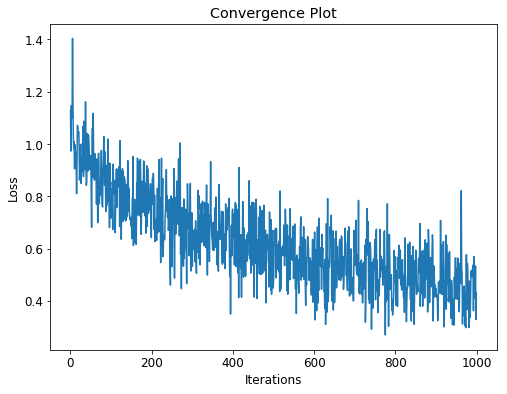

In [17]:
# visualize the convergence or course
# we can also do this within tensorboard
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

plt.plot(history)
plt.title('Convergence Plot')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

We will mimick a command line call by putting a `!` exclamation mark in the beginning of the code cell, note that if we are using the `!` to mimick command line calls, we can't use python's variable when passing the logging directory of tensorboard to the command line call, it won't work.

In [14]:
hi

NameError: name 'hi' is not defined

In [ ]:
!tensorboard --logdir='./graphs/no_frills/' --port=8000

To terminate the tensorboard visualization in jupyter notebook we can go to the dropdown menu at the top: `Kernel -> Interrupt`

In [ ]:
from scipy.spatial.distance import cdist


top_k = 5
idx = word_index['computer']

eval_word = word_index_rev[idx]
print(eval_word)

# remember the cdist returns a the cosine distance,
# so when doing the argsort, which is sorting by ascending
# order, the top k most similar word will be the first k one;
# and since the most similar word will always be itself, we
# exclude that from the returned result
vector = word_vectors[idx].reshape(1, -1)
sim = cdist(word_vectors, vector, metric = 'cosine').ravel()
nearest_indices = np.argsort(sim)[1:(top_k + 1)]
for nearest_idx in nearest_indices:
    sim_word = word_index_rev[nearest_idx]
    print(sim_word)

# Reference

- [Blog: Word2Vec Tutorial - The Skip-Gram Model](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)
- [Note: CS 20SI Lecture note 4: How to structure your model in TensorFlow](http://web.stanford.edu/class/cs20si/lectures/notes_04.pdf)
- [Paper: Yoav Goldberg, Omer Levy (2014) word2vec Explained: deriving Mikolov et al.'s negative-sampling word-embedding method](https://arxiv.org/abs/1402.3722)